# Comparing Physics Based and Regular Models Trained on Flat/No Displacement Conditions on Curved + Displacement Condition
Does the physics-based loss give us any extra advantage when working in an unseen condition?

In [1]:
# Load un-procesed data from the Randall's Pickle files and process it
from pathlib import Path
import pandas as pd

DATA_PATH = Path(
    r"/home/rlfowler/Documents/research/tfo_inverse_modelling/Randalls Folder/data/randall_data_intensities.pkl"
)
data = pd.read_pickle(DATA_PATH)

# Filter out the data that is not useful
CHOSEN_FETAL_RADIUS = 450.0
CHOSEN_FETAL_DISPLACEMENT = 5.0
MATERNAL_SATURATION_CUTOFF = 0.92
FETAL_SATURATION_CUTOFF = 0.3
MATERNAL_CONC_CUTOFF = 13.
FETAL_CONC_CUTOFF = 12.8

data = data[
    (data["Fetal Radius"] == CHOSEN_FETAL_RADIUS)
    & (data["Fetal Displacement"] == CHOSEN_FETAL_DISPLACEMENT)
    & (data["Maternal Saturation"] > MATERNAL_SATURATION_CUTOFF)
    & (data["Fetal Saturation"] > FETAL_SATURATION_CUTOFF)
    & (data["Maternal Hb Concentration"] < MATERNAL_CONC_CUTOFF)
    & (data["Fetal Hb Concentration"] < FETAL_CONC_CUTOFF)
]
print("Data Shape: ", data.shape)

Data Shape:  (9216, 47)


In [2]:
data["Fetal Hb Concentration"].unique()

array([10.725 , 11.    , 11.2125, 11.275 , 11.5   , 11.7   , 11.7875,
       12.    , 12.1875, 12.3   , 12.5   , 12.675 ], dtype=float32)

In [3]:
# Create AC Terms using this mapping
import numpy as np
from inverse_modelling_tfo.features.build_features import FetalACbyDCFeatureBuilder

rounding_points = 2
grouping_map = {
    10.72: 0,
    11.0: 0,
    11.28: 1,
    11.5: 1,
    11.79: 2,
    12.0: 2,
    12.3: 3,
    12.5: 3,
}
# Need to typecast as float32 since the original column is also in float32!
grouping_map = {np.float32(round(float(k), rounding_points)): v for k, v in grouping_map.items()}
data["FconcCenters"] = (data["Fetal Hb Concentration"].round(rounding_points)).map(grouping_map)
data = data.dropna()  # In case there are any NaNs

intensity_columns = list(filter(lambda x: x.endswith(".0"), data.columns))
labels = [
    "Maternal Wall Thickness",
    "Fetal Radius",
    "Fetal Displacement",
    "Maternal Hb Concentration",
    "Maternal Saturation",
    "Fetal Hb Concentration",
    "Fetal Saturation",
    "FconcCenters",
]

fb1 = FetalACbyDCFeatureBuilder("FconcCenters", "comb", intensity_columns, labels, "max")
data = fb1(data)

pulsation_ratio = fb1.get_feature_names()


data.head()

,Maternal Wall Thickness,Fetal Radius,Fetal Displacement,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,MAX_ACbyDC_WV1_10.0,...,MAX_ACbyDC_WV1_77.0,MAX_ACbyDC_WV2_77.0,MAX_ACbyDC_WV1_81.0,MAX_ACbyDC_WV2_81.0,MAX_ACbyDC_WV1_86.0,MAX_ACbyDC_WV2_86.0,MAX_ACbyDC_WV1_90.0,MAX_ACbyDC_WV2_90.0,MAX_ACbyDC_WV1_94.0,MAX_ACbyDC_WV2_94.0
0,2.0,450.0,5.0,11.0,0.93,0.35,0.0,10.7250,11.0,0.001545,...,0.002501,0.096281,0.108627,0.057995,0.024698,0.285932,0.137665,0.053882,0.166272,0.043394
1,2.0,450.0,5.0,11.0,0.93,0.35,1.0,11.2750,11.5,0.001220,...,0.001921,0.073393,0.089452,0.040471,0.019870,0.239881,0.113962,0.041216,0.137084,0.035602
2,2.0,450.0,5.0,11.0,0.93,0.35,2.0,11.7875,12.0,0.001106,...,0.001731,0.065522,0.084428,0.032501,0.018520,0.227082,0.107847,0.037572,0.129120,0.033639
3,2.0,450.0,5.0,11.0,0.93,0.35,3.0,12.3000,12.5,0.001001,...,0.001571,0.059045,0.079440,0.025994,0.017256,0.213909,0.101717,0.034688,0.121322,0.031683
4,2.0,450.0,5.0,11.0,0.93,0.40,0.0,10.7250,11.0,0.001527,...,0.002567,0.095310,0.104864,0.056421,0.024224,0.288485,0.132674,0.053313,0.161502,0.043871


In [ ]:
# Generate Pathlength stats for the data
import json
from glob import glob
import pandas as pd
from tfo_sim.simulation_jobs.generate_pathlength_stats import generate_pathlength_stats
from tfo_sim.misc import generate_sdd_column

RAW_DATA_PATH = Path(r"/home/rlfowler/Documents/research/tfo_sim/data/raw_dan_iccps_RD1")
raw_files = list(glob(str(RAW_DATA_PATH / "*.pkl")))
raw_files = [Path(f) for f in raw_files]

pathlength_stats = pd.DataFrame()

for raw_file in raw_files:
    # Only process the files with the correct radius and displacement
    if f'fr_{int(CHOSEN_FETAL_RADIUS)}' not in raw_file.name:
        continue
    if f'fd_{int(CHOSEN_FETAL_DISPLACEMENT)}' not in raw_file.name:
        continue
    # Load data & generate SDD column
    raw_data = pd.read_pickle(raw_file)
    sdd_col = generate_sdd_column(raw_data).astype(int)  # Convert to int for comparison purposes

    # Get config
    config_file = raw_file.with_suffix(".json")
    with open(config_file, "r", encoding="utf-8") as f:
        config_file = json.load(f)

    # Generate pathlength stats
    column_names = list(filter(lambda x: x.endswith("ppath"), raw_data.columns))
    stats_columns = generate_pathlength_stats(raw_data[column_names], sdd_col)

    # Additional columns for indexing later on - I currently only have these two
    stats_columns["Maternal Wall Thickness"] = config_file["dermis_thickness"]  # pandas complains here/ignore
    stats_columns["Wave Int"] = config_file["wave_int"]  # pandas complains here/ignore

    # Append to the all_stats DataFrame
    pathlength_stats = pd.concat([pathlength_stats, stats_columns], axis=0, ignore_index=True)

In [5]:
# Combine the data to create the physics-based term
l4_mean_column_names = list(filter(lambda x: 'L4 ppath_mean' in x, pathlength_stats.columns))
wv1_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 1])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv2_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 2])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv1_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
wv2_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
pathlength_stats.drop(columns=['Wave Int'], inplace=True)   # Don't need this column anymore

# Append the pathlength stats to the data
for column in wv1_ppath.columns:
    data[column + ' WV1'] = data['Maternal Wall Thickness'].map(wv1_ppath[column])
for column in wv2_ppath.columns:
    data[column + ' WV2'] = data['Maternal Wall Thickness'].map(wv2_ppath[column])

# Defining feature groups
wv1_pulsation_ratio = list(filter(lambda x: 'WV1' in x, pulsation_ratio))
wv2_pulsation_ratio = list(filter(lambda x: 'WV2' in x, pulsation_ratio))
wv1_ppath = [x + ' WV1' for x in l4_mean_column_names]  # Replace with the new column names
wv2_ppath = [x + ' WV2' for x in l4_mean_column_names]  # Replace with the new column names

# Pulsation Ratio copy (This will be left unscaled)
unscaled_pulsation_ratio_columns = [x + ' unscaled' for x in pulsation_ratio]
temp = data[pulsation_ratio]
temp.columns = unscaled_pulsation_ratio_columns
data = pd.concat([data, temp], axis=1)  # Avoids contiguity issues
data.head()

,Maternal Wall Thickness,Fetal Radius,Fetal Displacement,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,MAX_ACbyDC_WV1_10.0,...,MAX_ACbyDC_WV2_55.0 unscaled,MAX_ACbyDC_WV2_59.0 unscaled,MAX_ACbyDC_WV2_64.0 unscaled,MAX_ACbyDC_WV2_68.0 unscaled,MAX_ACbyDC_WV2_72.0 unscaled,MAX_ACbyDC_WV2_77.0 unscaled,MAX_ACbyDC_WV2_81.0 unscaled,MAX_ACbyDC_WV2_86.0 unscaled,MAX_ACbyDC_WV2_90.0 unscaled,MAX_ACbyDC_WV2_94.0 unscaled
0,2.0,450.0,5.0,11.0,0.93,0.35,0.0,10.7250,11.0,0.001545,...,0.047296,0.053845,0.048736,0.060482,0.099368,0.096281,0.057995,0.285932,0.053882,0.043394
1,2.0,450.0,5.0,11.0,0.93,0.35,1.0,11.2750,11.5,0.001220,...,0.037093,0.042637,0.039273,0.045351,0.075209,0.073393,0.040471,0.239881,0.041216,0.035602
2,2.0,450.0,5.0,11.0,0.93,0.35,2.0,11.7875,12.0,0.001106,...,0.033543,0.038946,0.036572,0.039622,0.065789,0.065522,0.032501,0.227082,0.037572,0.033639
3,2.0,450.0,5.0,11.0,0.93,0.35,3.0,12.3000,12.5,0.001001,...,0.030239,0.035499,0.034034,0.034841,0.057718,0.059045,0.025994,0.213909,0.034688,0.031683
4,2.0,450.0,5.0,11.0,0.93,0.40,0.0,10.7250,11.0,0.001527,...,0.047297,0.053954,0.049037,0.059759,0.098355,0.095310,0.056421,0.288485,0.053313,0.043871


In [7]:
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua0_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua1_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua0_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=1)
    return mu_a

def calculate_mua1_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=1)
    return mu_a

data["Fetal Mua 0 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
data["Fetal Mua 1 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
data["Fetal Mua 0 WV1"] = data.apply(calculate_mua0_wv1, axis=1)
data["Fetal Mua 1 WV1"] = data.apply(calculate_mua1_wv1, axis=1)

data["Delta Mu WV2"] = data["Fetal Mua 1 WV2"] - data["Fetal Mua 0 WV2"]
data["Delta Mu WV1"] = data["Fetal Mua 1 WV1"] - data["Fetal Mua 0 WV1"]

# Generate the BL columns
# Create an empty dataframe, fillup with BLs, concat back into original, this way avoids data contiguity issues
bl_column_names = [f'{column}_BL WV1' for column in l4_mean_column_names] + [f'{column}_BL WV2' for column in l4_mean_column_names]
unscaled_bl_df = pd.DataFrame(columns=bl_column_names)
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    unscaled_bl_df[f'{column}_BL WV1'] = data[wv1_column] * (data['Fetal Mua 0 WV1'] - data['Fetal Mua 1 WV1'])
    unscaled_bl_df[f'{column}_BL WV2'] = data[wv2_column] * (data['Fetal Mua 0 WV2'] - data['Fetal Mua 1 WV2'])
data = pd.concat([data, unscaled_bl_df], axis=1)
# Get the indices
bl_column_indices = [data.columns.get_loc(column) for column in bl_column_names]

/tmp/ipykernel_2612100/1564290025.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Fetal Mua 0 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
/tmp/ipykernel_2612100/1564290025.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Fetal Mua 1 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
/tmp/ipykernel_2612100/1564290025.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

# Training Objective

In [9]:
y_columns = ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2'] + wv1_ppath + wv2_ppath  # MuA + Partial pathlengths
x_columns = pulsation_ratio

# Load Scalers and Models

In [10]:
# Load Model Code
from inverse_modelling_tfo.model_training.custom_models import PerceptronBD
import torch
import joblib

IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

physics_loss_model = PerceptronBD([IN_FEATURES, 80, 50, OUT_FEATURES]) 
physics_loss_model.load_state_dict(torch.load(r'../../models/physics_loss_pr_to_mua.pth'))
physics_loss_model = physics_loss_model.cuda()

regular_model = PerceptronBD([IN_FEATURES, 80, 50, OUT_FEATURES])
regular_model.load_state_dict(torch.load(r'../../models/no_physics_loss_pr_to_mua.pth'))
regular_model = regular_model.cuda()

# They bothuse the same scalers!
x_scaler = joblib.load(r'../../models/physics_loss_pr_to_mua_xscaler')
y_scaler = joblib.load(r'../../models/physics_loss_pr_to_mua_yscaler')

# Comparing Predictions 

In [11]:
# Scale data & Generate Dataloaders
data[y_columns] = y_scaler.fit_transform(data[y_columns])
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [15]:
from inverse_modelling_tfo.model_training import DataLoaderGenerator3, RandomSplit

dataloader_gen = DataLoaderGenerator3(data, x_columns, y_columns, unscaled_pulsation_ratio_columns, 4096, {})
loader1, _ = dataloader_gen.generate(RandomSplit(0.9999))   # All goes in the first split

In [16]:
from inverse_modelling_tfo.visualization.distributions import generate_model_error_and_prediction
# MAE 
phy_error, phy_pred = generate_model_error_and_prediction(physics_loss_model, loader1, y_columns, y_scaler)
reg_error, reg_pred = generate_model_error_and_prediction(regular_model, loader1, y_columns, y_scaler)

# Visualization

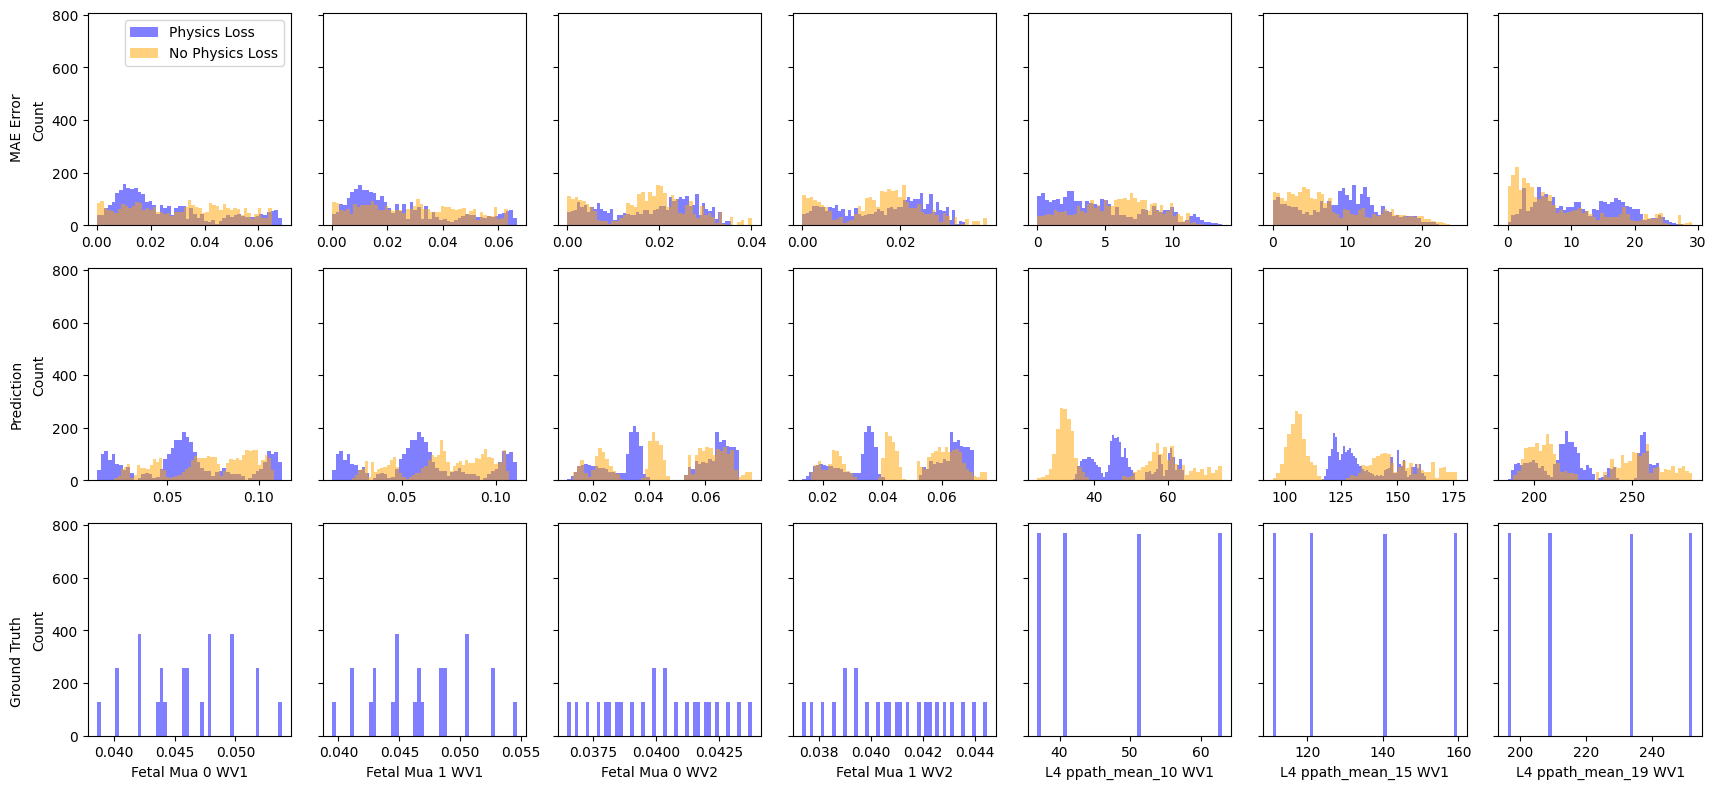

In [17]:
import matplotlib.pyplot as plt
PLOT_FIRST_N = 7
y_columns_to_plot = y_columns[:PLOT_FIRST_N]
fig_dist, axes = plt.subplots(3, len(y_columns_to_plot), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

ground_truth = y_scaler.inverse_transform(loader1.dataset[:][1].cpu())

for i in range(len(y_columns_to_plot)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = phy_error.columns[i]
    plt.hist(phy_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Physics Loss')
    plt.hist(reg_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='No Physics Loss')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = phy_pred.columns[i]
    plt.hist(phy_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Physics Loss')
    plt.hist(reg_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='No Physics Loss')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(ground_truth[:, i], bins=BIN_COUNT, color='blue', alpha=0.5)

    # X Label for the bottommost row
    plt.xlabel(y_columns_to_plot[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()

plt.tight_layout()
plt.show()